In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import os
import nltk
import re
import keras
from keras import Model
import csv
import matplotlib.pyplot as plt

# out libraries
import Utils.W2V as wor2vec
from Utils.classifier import create_Trumpifier
from Utils.genetic_algorithm import GeneticAlgorithm

from keras.callbacks import ModelCheckpoint
# random seed
rseed = 12345678

/home/alessandro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load raw data
Eminem_df = pd.read_csv('processedData/Eminem_tweets.csv',delimiter="|", header=None)
newTrump_df = pd.read_csv('processedData/TestDonaldTrump_tweets.csv',delimiter="|", header=None)
notTrump_df = pd.read_csv('processedData/processedDataNotDonaldTrump.csv',delimiter="|", header=None)
Trump_df = pd.read_csv('processedData/processedDataDonaldTrump.csv',delimiter="|", header=None)


# delete special characters, generate labels and training data for word2vec
# test set
X_trump = ["".join(re.split('[`\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?]', t)).split() for t in Trump_df[1].values.tolist()]
y_trump = np.zeros(len(X_trump), dtype=int)

X_eminem = ["".join(re.split('[`\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?]', t)).split() for t in Eminem_df[1].values.tolist()]
y_eminem = np.ones(len(X_eminem), dtype=int)

# training set
X_t = ["".join(re.split('[`\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?]', t)).split() for t in Trump_df[1].values.tolist()]
y_t = np.zeros(len(X_t), dtype=int)

X_nt = ["".join(re.split('[`\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?]', t)).split() for t in notTrump_df[1].values.tolist()]
y_nt = np.ones(len(X_nt), dtype=int)

# make random combinations of each tweet
X_random_eminem = []
X_random_trump = []
X_random_t = []
X_random_nt = []

for i in range(len(X_eminem)):
    row = X_eminem[i].copy()
    np.random.shuffle(row)
    X_random_eminem.append(row)

for i in range(len(X_trump)):
    row = X_trump[i].copy()
    np.random.shuffle(row)
    X_random_trump.append(row)

for i in range(len(X_t)):
    row = X_t[i].copy()
    np.random.shuffle(row)
    X_random_t.append(row)

for i in range(len(X_nt)):
    row = X_nt[i].copy()
    np.random.shuffle(row)
    X_random_nt.append(row)
    
y_random_t = np.ones(len(X_random_t), dtype=int) * 2
y_random_nt = np.ones(len(X_random_nt), dtype=int) * 2
y_random_eminem = np.ones(len(X_random_eminem), dtype=int) * 2
y_random_trump = np.ones(len(X_random_trump), dtype=int) * 2

# Convert all data to vectors
vec_size = 100
tweet_len = 70

w2v_ds = np.concatenate((X_t, X_nt, X_random_t, X_random_nt, X_eminem, X_trump, X_random_eminem, X_random_trump))

# use words not contained in tw
USE_NO_TWEET_W = False

w2v = wor2vec.W2V(out_size = vec_size, fname="test_w2v_eminem")
# w2v.create_w2v(w2v_ds, USE_NO_TWEET_W)
w2v.load_w2v()
w2v_dict = w2v.dictionary

# merge all data
X_train = np.concatenate((X_t, X_nt, X_random_t, X_random_nt))
y = np.concatenate((y_t, y_nt, y_random_t, y_random_nt))
y_train = keras.utils.to_categorical(y)
X_vec_train = w2v.vectorize_words(X_train, tweet_len)

2018-06-19 20:18:44,663 : INFO : loading Word2Vec object from ./Utils/w2v_models/test_w2v_eminem
2018-06-19 20:18:46,105 : INFO : loading wv recursively from ./Utils/w2v_models/test_w2v_eminem.wv.* with mmap=None
2018-06-19 20:18:46,106 : INFO : setting ignored attribute vectors_norm to None
2018-06-19 20:18:46,107 : INFO : loading vocabulary recursively from ./Utils/w2v_models/test_w2v_eminem.vocabulary.* with mmap=None
2018-06-19 20:18:46,108 : INFO : loading trainables recursively from ./Utils/w2v_models/test_w2v_eminem.trainables.* with mmap=None
2018-06-19 20:18:46,109 : INFO : setting ignored attribute cum_table to None
2018-06-19 20:18:46,109 : INFO : loaded ./Utils/w2v_models/test_w2v_eminem
2018-06-19 20:18:46,222 : INFO : saving Word2Vec object under ./Utils/w2v_models/test_w2v_eminem, separately None
2018-06-19 20:18:46,223 : INFO : not storing attribute vectors_norm
2018-06-19 20:18:46,223 : INFO : not storing attribute cum_table
2018-06-19 20:18:47,283 : INFO : saved ./Uti

Length input = 171044
Length output = 171044
Unknown words = 0


In [3]:
# # split train and test
# X_train, X_test, y_trainn, y_test = train_test_split(X_vec_train, y_train, test_size=0.20, shuffle=True, random_state=rseed)

# X_train = np.array([np.array(x) for x in X_train])
# X_test = np.array([np.array(x) for x in X_test])

In [5]:
# classifier = create_Trumpifier(in_size = (tweet_len, vec_size), out_size = len(y_trainn[0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 70, 100)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 68, 64)            19264     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 66, 32)            6176      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 66, 64)            10304     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 33, 64)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 33, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 33, 32)            2080      
__________

In [6]:
# classifier.evaluate(X_test, y_test, batch_size=512, verbose=1)

34209/34209 [==============================] - 14s 419us/step


[0.7287548429894396, 0.6085923083980087]

In [2]:
Trumpifier_name = "Final_test_eminem_trumpifier.h5"
# load pretrained model
classifier = keras.models.load_model(os.path.join("./Utils/w2v_models/", Trumpifier_name))


# Fit the model
# checkpoint = ModelCheckpoint(os.path.join("./Utils/w2v_models/", Trumpifier_name), 
#                              monitor='val_loss', 
#                              verbose=1, 
#                              save_best_only=True)
# earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                           patience=10, 
#                                           verbose=1)

# classifier.fit(X_train, y_trainn, 
#                validation_split = 0.2,
#                epochs = 100, 
#                batch_size = 1024,
#                callbacks = [checkpoint, earlyStop]
#               )

In [12]:
# classifier.evaluate(X_test, y_test, batch_size=32, verbose=1)

34209/34209 [==============================] - 2s 62us/step


[0.24857558530668855, 0.8884504280267636]

69230/69230 [==============================] - 5s 65us/step
[0.2568711500810213, 0.8800472058554907]


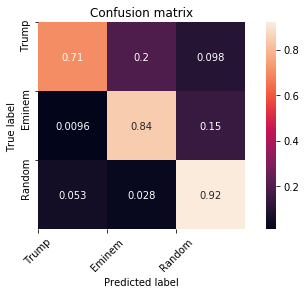

In [5]:
# create dataset for testing classifier
X_new_test = np.concatenate((X_eminem, X_trump, X_random_eminem, X_random_trump))
y = np.concatenate((y_eminem, y_trump, y_random_eminem, y_random_trump))
y_new_test = keras.utils.to_categorical(y)
X_vec_test = w2v.vectorize_words(X_new_test, tweet_len)

X_test_new = np.array([np.array(x) for x in X_vec_test])

predictions = classifier.predict(X_test_new)
print(classifier.evaluate(X_test_new, y_new_test))


cm = confusion_matrix(np.argmax(y_new_test, 1), np.argmax(predictions, 1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure()
ax =plt.subplot()
plt.imshow(cm, interpolation='nearest')
sns.heatmap(cm, annot=True, ax = ax);
plt.title("Confusion matrix")
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Trump", "Eminem", "Random"], rotation=45)
plt.yticks(tick_marks, ["Trump", "Eminem", "Random"])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

fig.savefig('cm_eminem.png')

In [3]:
# load raw data
notTrump_df = pd.read_csv('processedData/processedDataNotDonaldTrump.csv',delimiter="|", header=None)
Trump_df = pd.read_csv('processedData/processedDataDonaldTrump.csv',delimiter="|", header=None)

# delete special characters, generate labels and training data for word2vec
X_t = ["".join(re.split('[`\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?]', t)).split() for t in Trump_df[1].values.tolist()]
y_t = np.zeros(len(X_t), dtype=int)

X_nt = ["".join(re.split('[`\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?]', t)).split() for t in notTrump_df[1].values.tolist()]
y_nt = np.ones(len(X_nt), dtype=int)

# make random combinations of each tweet
X_random_t = []
X_random_nt = []

for i in range(len(X_t)):
    row = X_t[i].copy()
    np.random.shuffle(row)
    X_random_t.append(row)

for i in range(len(X_nt)):
    row = X_nt[i].copy()
    np.random.shuffle(row)
    X_random_nt.append(row)
    
y_random_t = np.ones(len(X_random_t), dtype=int) * 2
y_random_nt = np.ones(len(X_random_nt), dtype=int) * 2


# Convert all data to vectors
vec_size = 100
tweet_len = 70

w2v_ds = np.concatenate((X_t, X_nt, X_random_t, X_random_nt))

w2v = wor2vec.W2V(out_size = vec_size, fname="test_w2v_eminem")
# w2v.create_w2v(w2v_ds, USE_NO_TWEET_W)
w2v.load_w2v()
w2v_dict = w2v.dictionary


# merge all data
X = np.concatenate((X_t, X_nt, X_random_t, X_random_nt))
y = np.concatenate((y_t, y_nt, y_random_t, y_random_nt))
y = keras.utils.to_categorical(y)

X_vec = w2v.vectorize_words(X, tweet_len)

2018-06-19 20:39:07,747 : INFO : loading Word2Vec object from ./Utils/w2v_models/test_w2v_eminem
2018-06-19 20:39:09,189 : INFO : loading wv recursively from ./Utils/w2v_models/test_w2v_eminem.wv.* with mmap=None
2018-06-19 20:39:09,189 : INFO : setting ignored attribute vectors_norm to None
2018-06-19 20:39:09,190 : INFO : loading vocabulary recursively from ./Utils/w2v_models/test_w2v_eminem.vocabulary.* with mmap=None
2018-06-19 20:39:09,191 : INFO : loading trainables recursively from ./Utils/w2v_models/test_w2v_eminem.trainables.* with mmap=None
2018-06-19 20:39:09,191 : INFO : setting ignored attribute cum_table to None
2018-06-19 20:39:09,192 : INFO : loaded ./Utils/w2v_models/test_w2v_eminem
2018-06-19 20:39:09,303 : INFO : saving Word2Vec object under ./Utils/w2v_models/test_w2v_eminem, separately None
2018-06-19 20:39:09,303 : INFO : not storing attribute vectors_norm
2018-06-19 20:39:09,304 : INFO : not storing attribute cum_table
2018-06-19 20:39:10,031 : INFO : saved ./Uti

Length input = 171044
Length output = 171044
Unknown words = 0


171044/171044 [==============================] - 15s 85us/step
[0.24407939074309618, 0.8897866629363249]


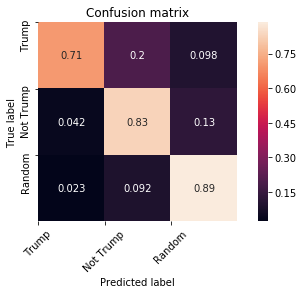

In [4]:
X_test = np.array([np.array(x) for x in X_vec])

predictions = classifier.predict(X_test)
print(classifier.evaluate(X_test, y, ))

cm = confusion_matrix(np.argmax(y, 1), np.argmax(predictions, 1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure()
ax =plt.subplot()
plt.imshow(cm, interpolation='nearest')
sns.heatmap(cm, annot=True, ax = ax);
plt.title("Confusion matrix")
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Trump", "Not Trump", "Random"], rotation=45)
plt.yticks(tick_marks, ["Trump", "Not Trump", "Random"])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

fig.savefig('cm_train.png')